# Multiclass logistic regression

https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html

In [1]:
import gzip
import array
import struct
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_int32(fin):
    buf = fin.read(4)
    return struct.unpack('>i', buf)[0]

def read_byte(fin):
    buf = fin.read(1)
    return struct.unpack('B', buf)[0]

def read_images(fin):
    magic = read_int32(fin)
    assert magic == 0x00000803, "magic number != 0x%08x" % magic
    num_images = read_int32(fin)
    num_rows = read_int32(fin)
    num_cols = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_images * num_rows * num_cols)
    return np.array(data).reshape((num_images, num_rows, num_cols))

def read_labels(fin):
    magic = read_int32(fin)
    assert magic == 0x00000801, "magic number != 0x%08x" % magic
    num_labels = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_labels)
    return np.array(data)

In [3]:
with gzip.open('data/3/train-images-idx3-ubyte.gz') as fin:
    train_images = read_images(fin)

with gzip.open('data/3/train-labels-idx1-ubyte.gz') as fin:
    train_labels = read_labels(fin)

with gzip.open('data/3/t10k-images-idx3-ubyte.gz') as fin:
    test_images = read_images(fin)

with gzip.open('data/3/t10k-labels-idx1-ubyte.gz') as fin:
    test_labels = read_labels(fin)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
def show_image(img):
    img = np.tile(img[:, :, np.newaxis], (1, 1, 3))
    plt.imshow(img, )

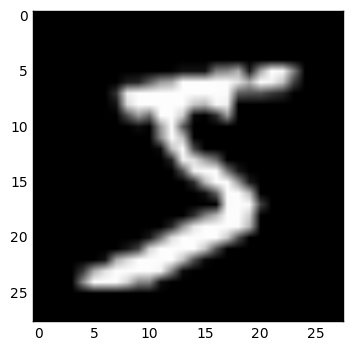

In [5]:
show_image(train_images[0])

In [6]:
train_labels[0]

5

In [7]:
num_examples, num_rows, num_cols = train_images.shape
num_tests, _, _ = test_images.shape
num_inputs = num_rows * num_cols
num_outputs = 10

In [8]:
train_data = train_images.reshape(num_examples, num_rows * num_cols)
test_data = test_images.reshape(num_tests, num_rows * num_cols)

In [9]:
train_data.shape, test_data.shape

((60000, 784), (10000, 784))

In [10]:
W = np.random.randn(num_inputs, num_outputs)
b = np.random.randn(num_outputs)